In [171]:
from prophet import Prophet
from prophet.plot import plot_plotly
import pandas as pd

In [172]:
#Reading the dataset
df = pd.read_excel("C:/Users/TEMP.NDOCY.000/Desktop/spaza_shop_sales_data_7_shops.xlsx")

df.columns = df.columns.str.replace(' ', '_').str.lower()
df['date'] = pd.to_datetime(df['date'], format="%Y/%m/%d")


In [173]:
min(df['date']),max(df['date'])

(Timestamp('2019-01-01 00:00:00'), Timestamp('2023-12-31 00:00:00'))

In [174]:
df.head(8)

,date,shop_id,product_id,product_name,sales_units,inventory_level,price_per_unit,revenue,local_event,day_of_week,holiday,season,supplier_delivery,supplier_name
0,2019-01-01,1,101,Bread,62,100,14.27,884.74,New Year,Tuesday,No,Summer,No,XYZ Supplier
1,2019-01-01,1,102,Milk,52,120,12.42,645.84,Festival,Tuesday,No,Summer,No,XYZ Supplier
2,2019-01-01,1,103,Flour,85,76,14.07,1195.95,New Year,Tuesday,No,Summer,No,XYZ Supplier
3,2019-01-01,1,104,Sugar,25,22,11.72,293.00,New Year,Tuesday,No,Summer,No,XYZ Supplier
4,2019-01-01,1,105,Tea,56,99,12.41,694.96,Festival,Tuesday,No,Summer,Yes,XYZ Supplier
5,2019-01-01,1,106,Coffee,95,48,10.67,1013.65,New Year,Tuesday,No,Summer,No,XYZ Supplier
6,2019-01-01,1,107,Rice,40,21,10.31,412.40,Community Event,Tuesday,No,Summer,No,XYZ Supplier
7,2019-01-01,2,101,Bread,36,77,11.84,426.24,NaN,Tuesday,No,Summer,Yes,ABC Supplier


In [175]:
# Check for missing data
missing_data = df.isnull().sum()

# Display the missing data count
print(missing_data)

date                     0
shop_id                  0
product_id               0
product_name             0
sales_units              0
inventory_level          0
price_per_unit           0
revenue                  0
local_event          22256
day_of_week              0
holiday                  0
season                   0
supplier_delivery        0
supplier_name            0
dtype: int64


In [176]:
# 1. Handle Missing Values
# Fill missing values in 'local_event' with 'No Event'
df['local_event'] = df['local_event'].fillna('No Event')

In [177]:
# Recheck for any other columns with missing values
missing_data = df.isnull().sum()
print("Missing Data after initial filling:")
print(missing_data)

Missing Data after initial filling:
date                 0
shop_id              0
product_id           0
product_name         0
sales_units          0
inventory_level      0
price_per_unit       0
revenue              0
local_event          0
day_of_week          0
holiday              0
season               0
supplier_delivery    0
supplier_name        0
dtype: int64


In [178]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

numerical_columns = ['sales_units', 'inventory_level', 'price_per_unit', 'revenue']

for column in numerical_columns:
    df = remove_outliers(df, column)

In [179]:
# Create additional time-based features for seasonality
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

In [180]:
# Create a column to capture seasonality impact
seasonal_impact = df.groupby(['season', 'month'])['sales_units'].mean().reset_index()
seasonal_impact.rename(columns={'sales_units': 'avg_sales_units'}, inplace=True)
df = df.merge(seasonal_impact, on=['season', 'month'], how='left')

In [181]:
# Create a column to capture local event impact
event_impact = df.groupby('local_event')['sales_units'].mean().reset_index()
event_impact.rename(columns={'sales_units': 'avg_event_sales_units'}, inplace=True)
df = df.merge(event_impact, on='local_event', how='left')

In [182]:
# Recheck for any remaining missing values
missing_data_after_cleaning = df.isnull().sum()
print("\nMissing Data after preprocessing:")
print(missing_data_after_cleaning)


Missing Data after preprocessing:
date                     0
shop_id                  0
product_id               0
product_name             0
sales_units              0
inventory_level          0
price_per_unit           0
revenue                  0
local_event              0
day_of_week              0
holiday                  0
season                   0
supplier_delivery        0
supplier_name            0
month                    0
year                     0
avg_sales_units          0
avg_event_sales_units    0
dtype: int64


In [183]:
df.to_excel("cleaned_dataset.xlsx", index=False)


In [184]:
# Load your cleaned dataset
df = pd.read_excel("cleaned_dataset.xlsx")


In [185]:
# Rename columns for Prophet: 'date' to 'ds' and 'sales_units' to 'y'
df_prophet = df[['date', 'sales_units']].copy()
df_prophet.rename(columns={'date': 'ds', 'sales_units': 'y'}, inplace=True)

In [186]:
# Convert 'ds' to datetime
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

In [187]:
# Define holidays and special events
holidays = pd.DataFrame({
    'holiday': 'special_event',
    'ds': pd.to_datetime(['2019-01-01', '2019-12-25', '2020-01-01']),  # Example holiday dates
    'lower_window': 0,
    'upper_window': 1,
})

In [188]:
# Initialize the Prophet model
model = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=True)

In [189]:
# Fit the model
model.fit(df_prophet)

02:16:44 - cmdstanpy - INFO - Chain [1] start processing
02:17:21 - cmdstanpy - INFO - Chain [1] done processing


In [190]:
# Make a future dataframe for predictions
future = model.make_future_dataframe(periods=365)  # Extend for 365 days into the future

In [191]:
# Make predictions
forecast = model.predict(future)

C:\Users\TEMP.NDOCY.000\AppData\Roaming\Python\Python312\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\TEMP.NDOCY.000\AppData\Roaming\Python\Python312\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
C:\Users\TEMP.NDOCY.000\AppData\Roaming\Python\Python312\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing

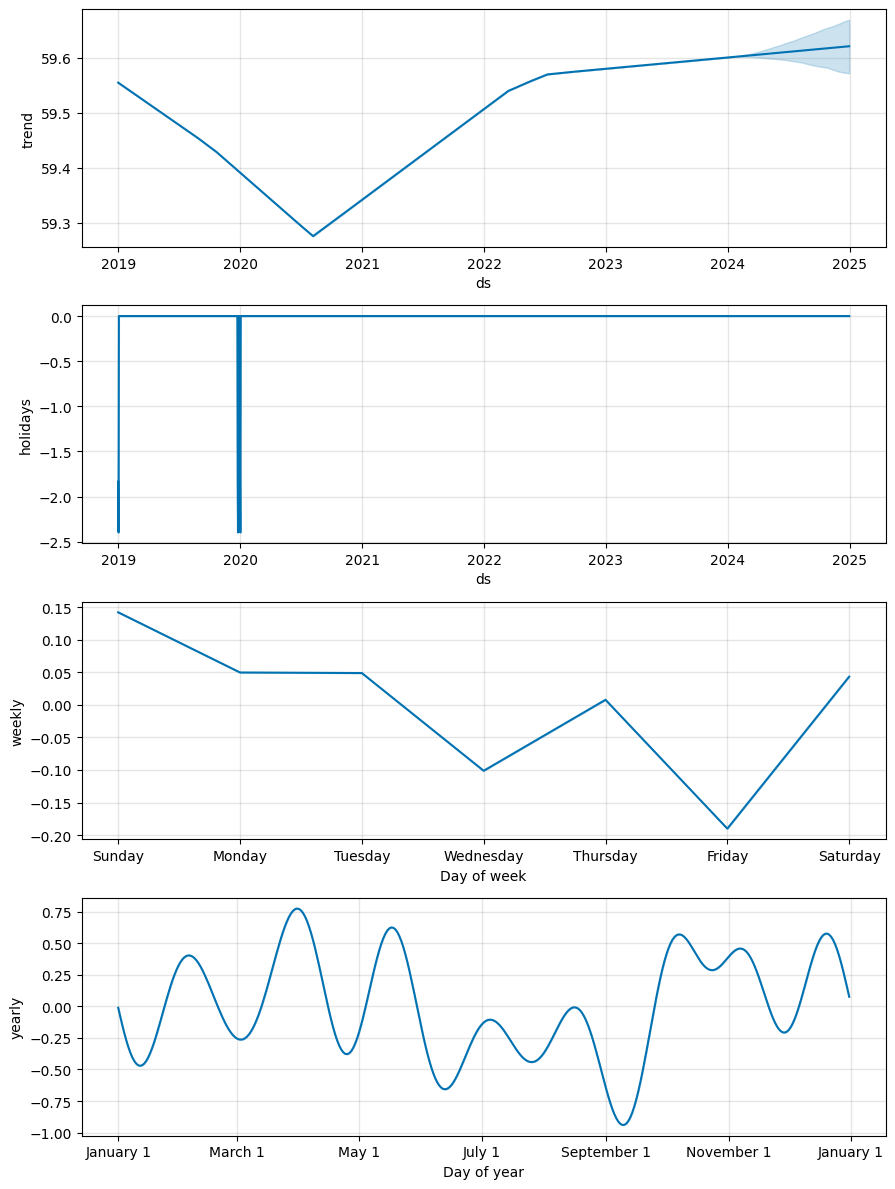

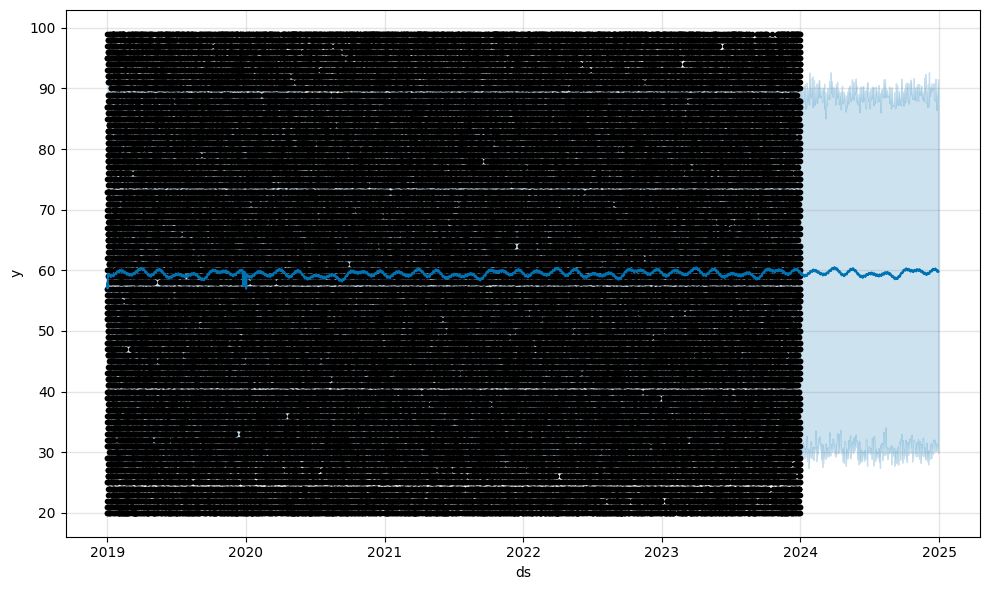

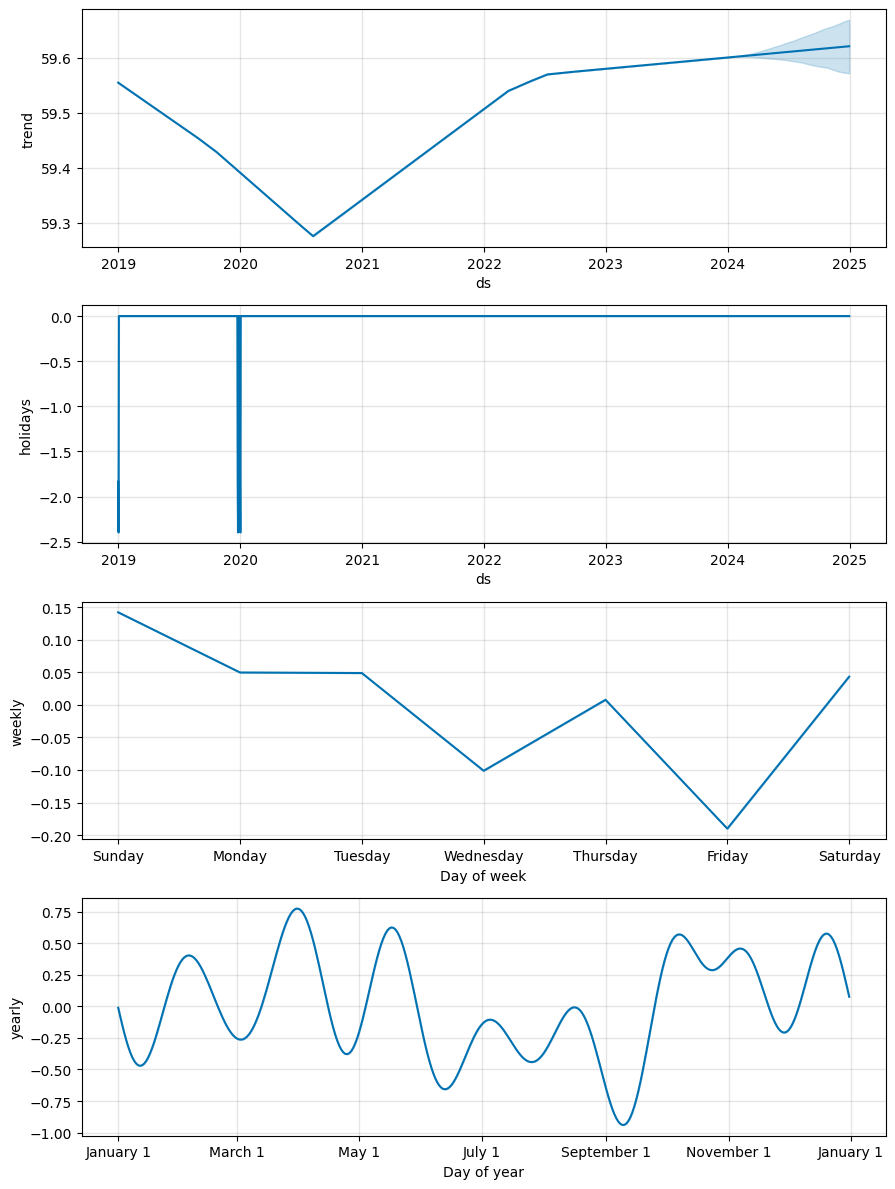

In [192]:
# Visualize the forecast
model.plot(forecast)
model.plot_components(forecast)